## ECON 323 Final Project
### An Analysis of Airbnb Prices Across Popular Countries in Europe


Karina Grewal (section 004), Hrithik Soni (section 003)

## Introduction

### Reading data

In [4]:
#loading necessary packages
#!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import glob, os
import seaborn as sns
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [5]:
#downloading datasets to a local folder
od.download("https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities")

Skipping, found downloaded files in "./airbnb-prices-in-european-cities" (use force=True to force download)


In [6]:
#accessing one dataset to take a peek at the data
amsterdam_weekdays = pd.read_csv('airbnb-prices-in-european-cities/amsterdam_weekdays.csv', index_col=0)
amsterdam_weekdays.head()

realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                        93.0         1  5.022964    2.539380   78.690379   
1                        85.0         1  0.488389    0.239404  631.176378   
2                        87.0         1  5.748312    3.651621   75.275877   
3                        90.0         2  0.384862    0.439876  493.272534   
4                        98.0         1  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat  
0         4.166708   98.253896         6.846473  4.90569  52.41772  
1        33.421209  837.280757        58.342928  4.90005  52.37432  
2         3.985908   95.386955         6.646700  4.97512  52.36103  
3        26.119108  875.033098        60.973565  4.89417  52.37663  
4        29.272733  815.305740        56.811677  4.90051  52.37508

In [7]:
#trying to download all datasets
path = r'airbnb-prices-in-european-cities' 

# Get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories
dfs = list()

#appending all the different files into dataframes by filename of form city_time
for i, f in enumerate(files):
    data = pd.read_csv(f, index_col=0).assign(City=os.path.basename(f).split('.')[0])
    dfs.append(data)

#Combining into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#splitting the file name into two columns with city name and weekday/weekend time period separate
df[['city', 'time']] = df.City.str.split("_", expand = True)
df = df.drop('City', axis=1)

#preview
df.head()

realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378   
2                        87.0  ...  5.748312    3.651621   75.275877   
3                        90.0  ...  0.384862    0.439876  493.272534   
4                        98.0  ...  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat       city  \
0         4.166708   98.253896         6.846473  4.90569  52.41772  amsterdam   
1        33.421209  837.280757        58.342928  4.90005  52.37432  amsterdam   
2         3.985908   95.386955         6.646700  4.97512  52.36103  amsterdam   
3        26.119108  875.033098        60.973565  4.89417  52.37663  amsterdam   
4        29.272733  815.305740        56.811677  4.90051  52.37508  amsterdam   

       time  
0  weekdays  
1  weekdays  
2  weekdays  
3  weekdays  
4  weekdays  

[5 rows x 21 columns]

### EDA

#### Plot #1

In [8]:
#Creating coordinates for geopandas to read
df["Coordinates"] = list(zip(df.lng, df.lat))
df["Coordinates"] = df["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...  metro_dist  attr_index  attr_index_norm  \
0                        93.0  ...    2.539380   78.690379         4.166708   
1                        85.0  ...    0.239404  631.176378        33.421209   
2                        87.0  ...    3.651621   75.275877         3.985908   
3                        90.0  ...    0.439876  493.272534        26.119108   
4                        98.0  ...    0.318693  552.830324        29.272733   

   rest_index  rest_index_norm      lng       lat       city      time  \
0   98.253896         6.846473  4.90569  52.41772  amsterdam  weekdays   
1  837.280757        58.342928  4.90005  52.37432  amsterdam  weekdays   
2   95.386955         6.646700  4.97512  52.36103  amsterdam  weekdays   
3  875.033098        60.973565  4.89417  52.37663  amsterdam  weekdays   
4  815.305740        56.811677  4.90051  52.37508  amsterdam  weekdays   

                Coordinates  
0  POINT (4.90569 52.41772)  
1  POINT (4.90005 52.37432)  
2  POINT (4.97512 52.36103)  
3  POINT (4.89417 52.37663)  
4  POINT (4.90051 52.37508)  

[5 rows x 22 columns]

In [9]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

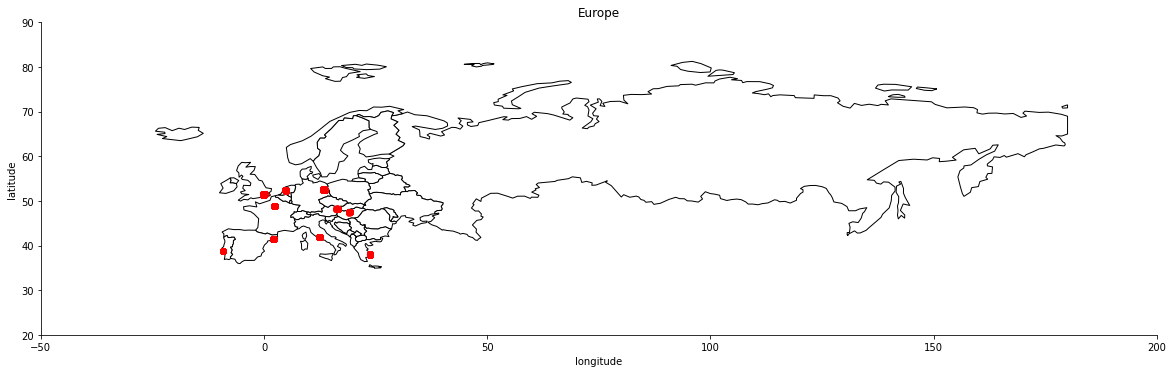

In [10]:
# Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(20,20))

# By only plotting rows in which the continent is 'Europe' we only plot, well,
# South America.
world.query("continent == 'Europe'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Europe')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.xlim(-50, 200)
plt.ylim(20, 90)

# Plotting the city names
# for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['city']):
#     gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')
    
plt.show()

### Plot #2

(0.0, 11000.0)

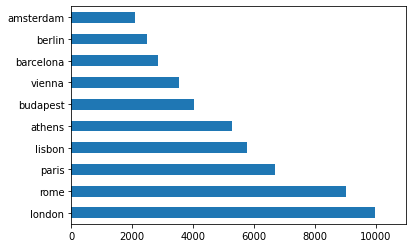

In [11]:
df["city"].value_counts().plot(kind = "barh")

plt.xlim(0, 11000)

### Plot #3: Price vs distance to city

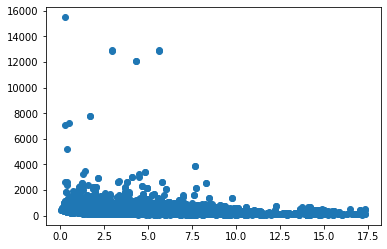

In [12]:
fig, ax = plt.subplots()

ams_rs = df.loc[df["city"] == "london"]["realSum"]
ams_cr = df.loc[df["city"] == "london"]["dist"]

ax.scatter(ams_cr, ams_rs)

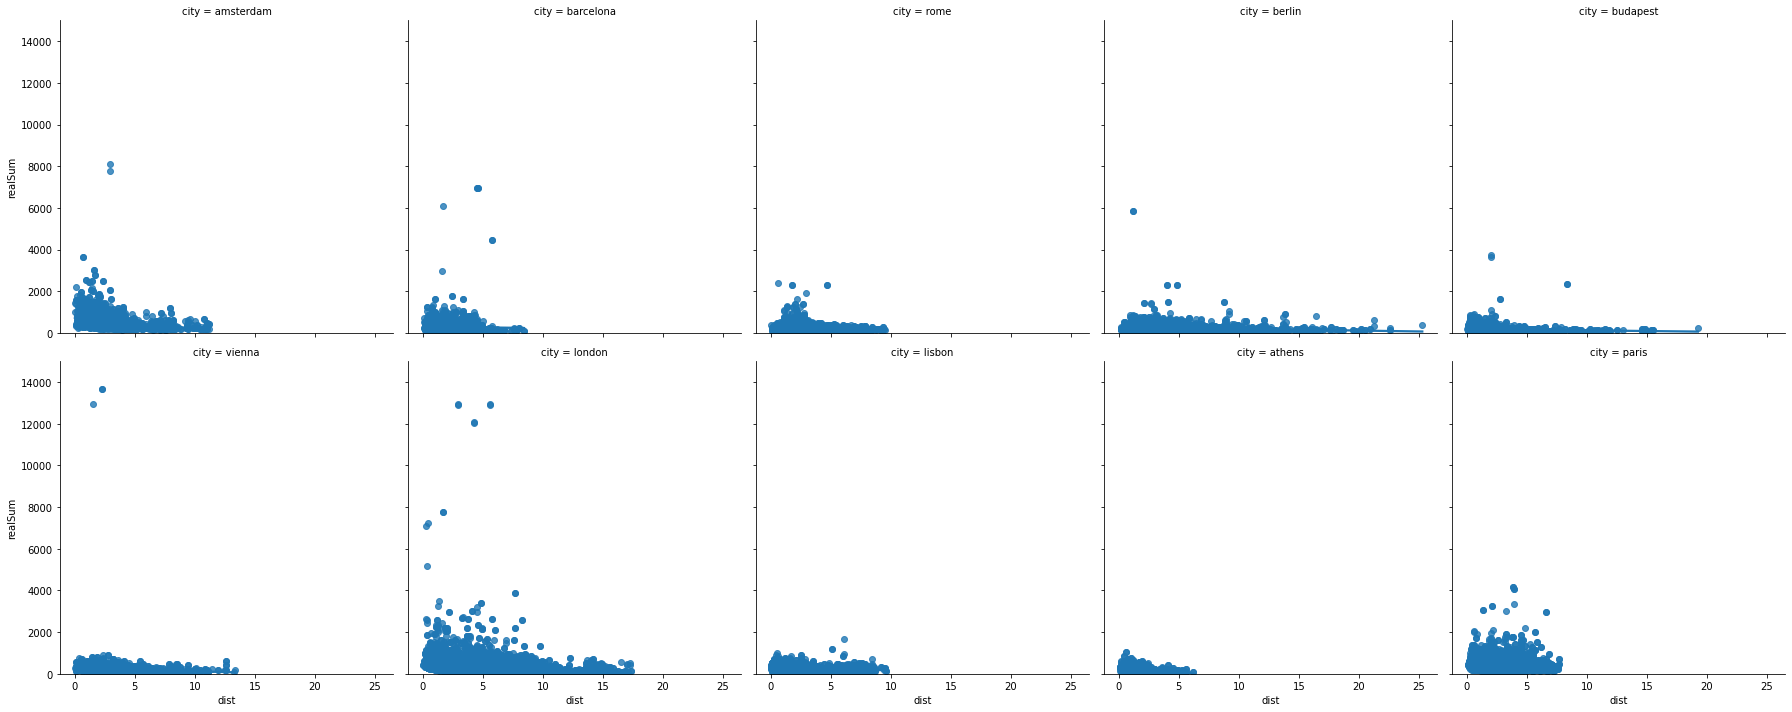

In [13]:
x = sns.lmplot(data=df, x='dist', y = 'realSum', col='city', col_wrap=5)
x.set(ylim = (0, 15000))

### Plot #4: Average price per city

<AxesSubplot: xlabel='city'>

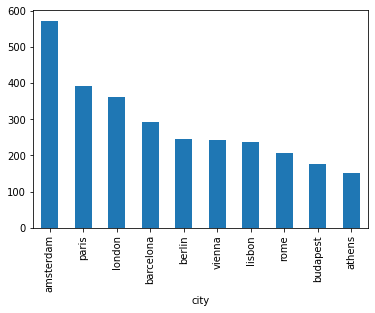

In [14]:
avg_price = df.groupby("city")["realSum"].mean()

avg_price.sort_values(ascending=False).plot.bar()

### Plot #5: Correlation heat map

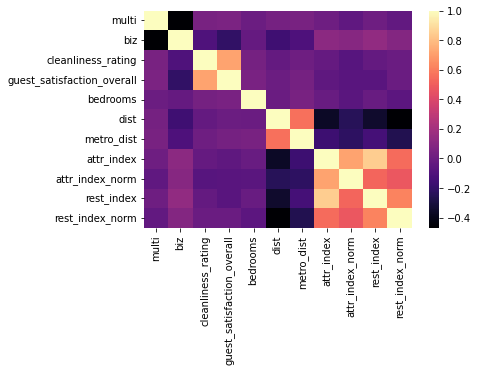

In [15]:
# Heatmap
df_heatmap = df.select_dtypes(include=np.number).iloc[:,2:-2]
df_heatmap

sns.heatmap(df_heatmap.corr(), annot = False, cmap = 'magma')
plt.show()

### Plot #6: Distribution Plot

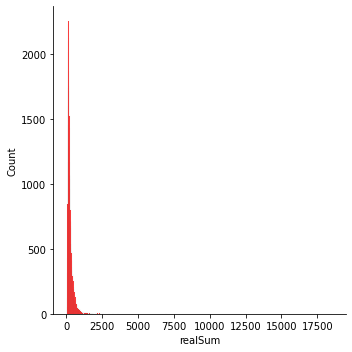

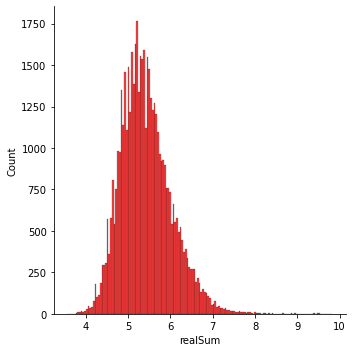

In [16]:
y = sns.displot(df['realSum'], color = 'r')

sns.displot(np.log(df['realSum']), color = 'r')

#### Plotting Continuous Variables

<ipython-input-17-e78fe5682724>:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


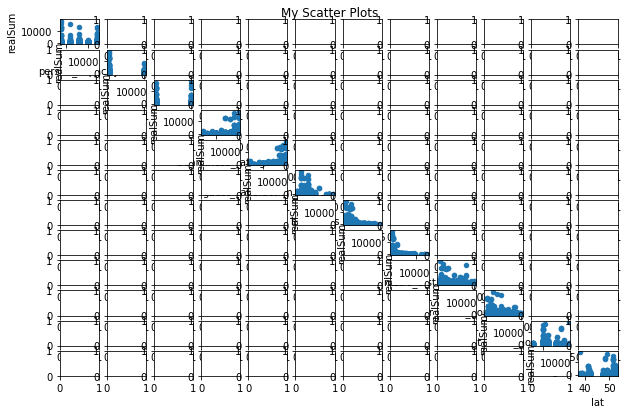

In [17]:
display_df = df[['realSum','person_capacity','multi', 'biz', 'cleanliness_rating', 
                   'guest_satisfaction_overall', 'bedrooms', 'dist',
                   'metro_dist','attr_index_norm', 'rest_index_norm', 'lng', 'lat']]

fig, ax = plt.subplots(12, 12 ,figsize=(10,6))

for i,col in enumerate(display_df.columns[1:]):
     display_df.plot(kind='scatter', x=col, y='realSum', ax=ax[i, i])
     # sns.regplot(x=display_df[col], y=display_df['realSum'], ax=ax[i])

# display_df.plot(kind='scatter', x="cleanliness_rating", y='realSum', ax=ax)

fig.suptitle('My Scatter Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)   

plt.show()

## Methods

### Prediction

#### 1. Full OLS

In [55]:
x = df.drop(["Coordinates", "realSum", "attr_index", "rest_index"], axis=1)
X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)
Y = np.log(df["realSum"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

airbnb_ols = linear_model.LinearRegression()
airbnb_ols.fit(X, Y)

metrics.mean_squared_error(y_test, airbnb_ols.predict(x_test))

# airbnb_ols = sm.OLS(y_train, x_train).fit()

# print(airbnb_ols.summary())

0.12266792974891769

#### 2. Forward/Backward selection

##### Feature Selection using AIC, BIC, Mallow's $C_p$, and adjusted $R^2$

In [69]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# forward
lr = linear_model.LinearRegression()

sfs = SFS(lr,
          k_features=5,
          verbose=2,
          forward = True,
          scoring='neg_mean_squared_error')

sfs = sfs.fit(x_train, y_train)

feat_names = list(sfs.k_feature_names_)
print(feat_names)

forward_xtrain_data = x_train[feat_names]
forward_xtest_data = x_test[feat_names]

forward_mod = lr.fit(forward_xtrain_data, y_train)
    
metrics.mean_squared_error(y_test, forward_mod.predict(forward_xtest_data))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s finished

[2023-04-07 15:28:31] Features: 1/5 -- score: -0.2793087671314515[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished

[2023-04-07 15:28:31] Features: 2/5 -- score: -0.2411781067018055[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.5s finished

[2023-04-07 15:28:31] Features: 3/5 -- score: -0.20390394375684623[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

['bedrooms', 'attr_index_norm', 'lng', 'room_type_Private room', 'city_lisbon']


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished

[2023-04-07 15:28:33] Features: 5/5 -- score: -0.16534738010990574

0.16018712182067743

In [71]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# backward
lr = linear_model.LinearRegression()

sfs = SFS(lr,
          k_features=5,
          verbose=2,
          forward = False,
          scoring='neg_mean_squared_error')

sfs = sfs.fit(x_train, y_train)

feat_names = list(sfs.k_feature_names_)
print(feat_names)

backward_xtrain_data = x_train[feat_names]
backward_xtest_data = x_test[feat_names]

backward_mod = lr.fit(forward_xtrain_data, y_train)
    
metrics.mean_squared_error(y_test, backward_mod.predict(backward_xtest_data))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.3s finished

[2023-04-07 15:28:57] Features: 23/5 -- score: -0.12817338654844015[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.1s finished

[2023-04-07 15:28:59] Features: 22/5 -- score: -0.1281705285645281[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.0s finished

[2023-04-07 15:29:01] Features: 21/5 -- score: -0.1281988286004767[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Do

['bedrooms', 'attr_index_norm', 'lng', 'room_type_Private room', 'city_lisbon']


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished

[2023-04-07 15:29:14] Features: 6/5 -- score: -0.15833989392752246[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished

[2023-04-07 15:29:14] Features: 5/5 -- score: -0.16534738010990574

0.16018712182067743

#### 3. Lasso Regression

##### Measuring MSE of the Prediction Models

In [19]:
#defining function to report mse values for models
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    report = dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )
    return print(f"{mod} reported mse: {report}")


fit_and_report_mses(linear_model.LinearRegression(), x_train, x_test, y_train, y_test)

LinearRegression() reported mse: {'mse_train': 0.1263058160882402, 'mse_test': 0.12766020492162639}


In [20]:
fit_and_report_mses(linear_model.Lasso(), x_train, x_test, y_train, y_test)

Lasso() reported mse: {'mse_train': 0.2721481205181504, 'mse_test': 0.270167433853339}


In [21]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_model.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

NameError: name 'lasso_model' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
# lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
# -np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

lasso_model = linear_model.Lasso()
lasso_model.fit(X, Y)

lasso_coefs = pd.Series(dict(zip(list(x_train), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), airbnb_ols.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

#### 3. Lasso Regression

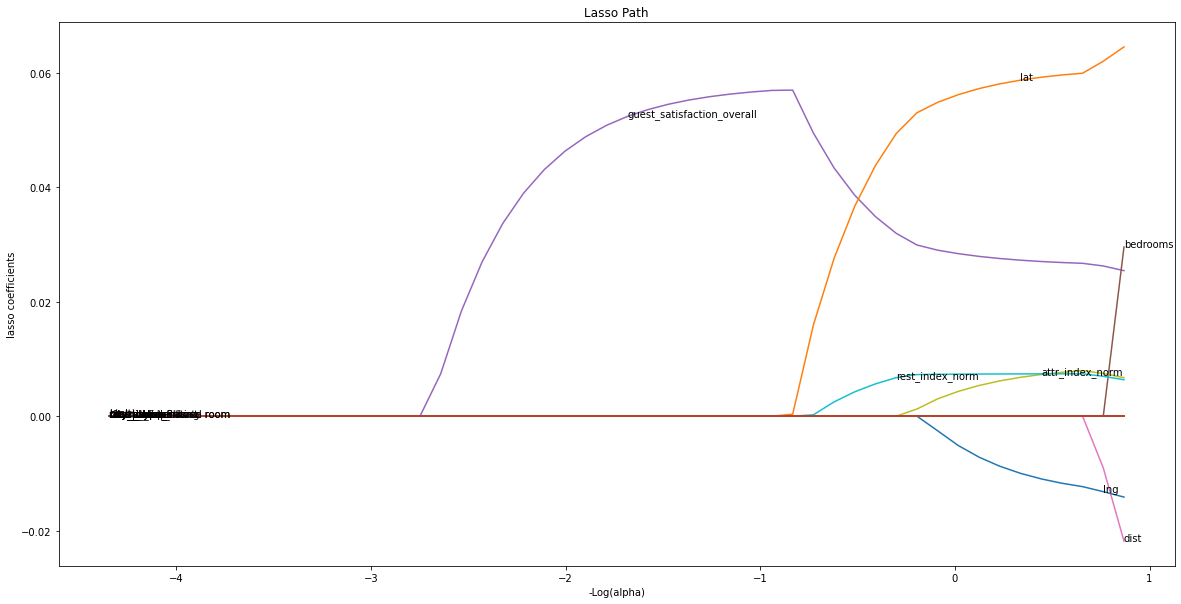

In [57]:
# alphas = np.linspace(0.01,500,100)
# lasso = Lasso(max_iter=10000)
# coefs = []

# for a in alphas:
#     lasso.set_params(alpha=a)
#     lasso.fit(x_train, y_train)
#     coefs.append(lasso.coef_)

# ax = plt.gca()

# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('Standardized Coefficients')
# plt.title('Lasso coefficients as a function of alpha');

from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(x_train, y_train, alphas=alphas, max_iter=10000)

# plotting
fig, ax = plt.subplots(figsize=(20,10))
log_alphas = -np.log10(alphas)
for coef_l, name in zip(coefs_lasso, list(x_train)):
   ax.plot(log_alphas, coef_l)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote))
    
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

In [58]:
# # Lasso with 5 fold cross-validation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# model = LassoCV(alphas=arange(0.01, 10, 0.01), cv=cv, random_state=0)

# # Fit model
# model.fit(x_train, y_train)

# print(model.alpha_)

# lasso_best = Lasso(alpha=model.alpha_)
# lasso_best.fit(x_train, y_train)

# mean_squared_error(y_test, lasso_best.predict(x_test))


lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

lasso_best = Lasso(alpha=lasso.alpha_)
lasso_best.fit(x_train, y_train)

mean_squared_error(y_test, lasso_best.predict(x_test))

0.13163694999476255

(0.0021910375899684975,
 4.371694733944378,
 0.12045963021380378,
 0.37707845826974606)

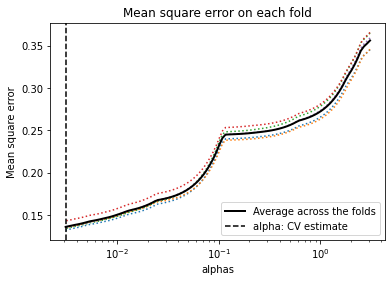

In [59]:
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(
    lasso.alphas_ ,
    lasso.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

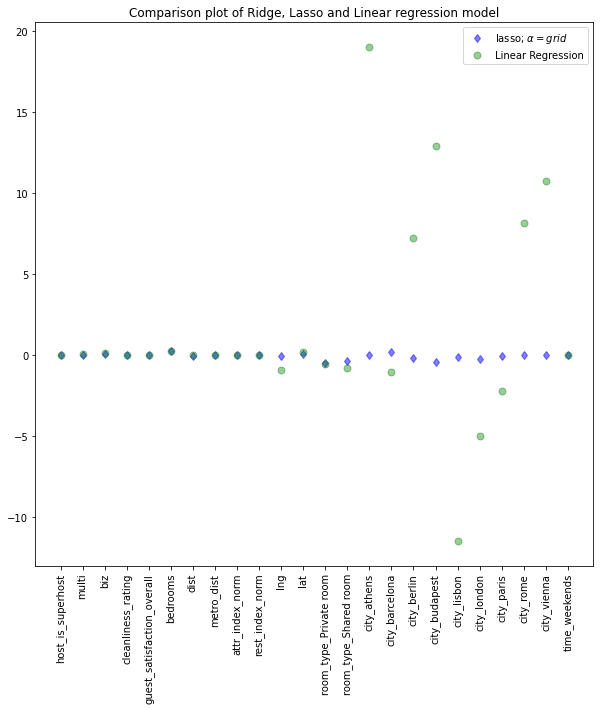

In [60]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

#### 4. Ridge Regression

In [61]:
# Standardizing predictor variables
list_numerical = X.columns[3:12]

scaler = StandardScaler().fit(x_train[list_numerical]) 

x_train[list_numerical] = scaler.transform(x_train[list_numerical])

x_test[list_numerical] = scaler.transform(x_test[list_numerical])

x_train

host_is_superhost  multi  biz  cleanliness_rating  \
38856                  0      0    0           -3.555429   
41683                  0      1    0           -0.411323   
14124                  0      0    0            0.636713   
40522                  0      1    0            0.636713   
15171                  0      0    0            0.636713   
...                  ...    ...  ...                 ...   
11051                  0      0    0            0.636713   
38821                  0      0    0           -0.411323   
15921                  0      0    1           -0.411323   
46034                  0      0    0           -0.411323   
43814                  0      0    1           -0.411323   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  \
38856                   -0.293234 -0.251723  0.849289   -0.279539   
41683                    0.041127 -0.251723 -0.539764   -0.402552   
14124                    0.821303  2.945728  0.217474   -0.411024   
40522                    0.152581 -0.251723  0.854283   -0.004393   
15171                    0.598396 -0.251723  0.797453   -0.182977   
...                           ...       ...       ...         ...   
11051                    0.821303 -0.251723 -0.484504   -0.122749   
38821                   -0.739049 -1.850449  0.603659   -0.519352   
15921                   -1.073411 -0.251723  2.289779    0.026703   
46034                   -0.404688 -0.251723 -0.733607   -0.019515   
43814                    0.041127  1.347003 -0.148688    1.698210   

       attr_index_norm  rest_index_norm  ...  city_athens  city_barcelona  \
38856        -0.175023         0.326166  ...            0               0   
41683         0.346849        -0.008583  ...            0               0   
14124         0.876933        -0.521720  ...            0               0   
40522        -0.701417        -1.172444  ...            0               0   
15171         0.468034        -0.734156  ...            0               0   
...                ...              ...  ...          ...             ...   
11051         0.166989        -1.033214  ...            0               0   
38821         0.547326         0.875967  ...            0               0   
15921        -0.452524        -0.989693  ...            0               0   
46034        -0.791059        -0.290713  ...            0               0   
43814        -1.020911        -0.654251  ...            0               0   

       city_berlin  city_budapest  city_lisbon  city_london  city_paris  \
38856            0              0            0            0           1   
41683            0              1            0            0           0   
14124            0              0            0            1           0   
40522            0              0            0            0           0   
15171            0              0            0            1           0   
...            ...            ...          ...          ...         ...   
11051            0              0            0            0           0   
38821            0              0            0            0           1   
15921            0              0            0            1           0   
46034            0              0            1            0           0   
43814            0              0            1            0           0   

       city_rome  city_vienna  time_weekends  
38856          0            0              0  
41683          0            0              1  
14124          0            0              0  
40522          0            1              1  
15171          0            0              0  
...          ...          ...            ...  
11051          0            1              0  
38821          0            0              0  
15921          0            0              0  
46034          0            0              0  
43814          0            0              0  

[38780 rows x 24 columns]

In [62]:
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# model = RidgeCV(alphas = arange(0.1, 10, 0.1), cv=cv, scoring='neg_mean_absolute_error')

# model.fit(x_train, y_train)

# print(model.alpha_)

# # Fit model
# ridge_best = Ridge(alpha = model.alpha_)
# ridge_best.fit(x_train, y_train)

# ridge_best = Ridge(alpha=model.alpha_)
# ridge_best.fit(x_train, y_train)

# mean_squared_error(y_test, ridge_best.predict(x_test))


ridge = linear_model.RidgeCV(cv=5).fit(x_train,y_train)
-np.log10(ridge.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

ridge_best = Ridge(alpha=ridge.alpha_)
ridge_best.fit(x_train, y_train)

mean_squared_error(y_test, ridge_best.predict(x_test))

0.12338764446628336

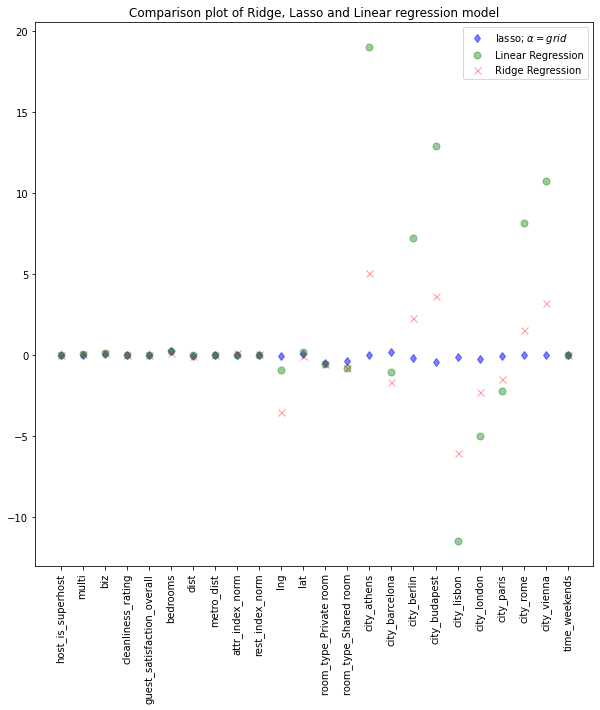

In [63]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#add plot for ridge model
plt.plot(list(x_train), ridge_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='red',label='Ridge Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

#### 5. Elastic Net

In [30]:
# from sklearn.linear_model import ElasticNetCV
# from sklearn.model_selection import RepeatedKFold

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define model
# ratios = np.arange(0, 1, 0.01)
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# # fit model
# model.fit(x_train, y_train)
# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)
# print('l1_ratio_: %f' % model.l1_ratio_)


/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/

alpha: 0.000000
l1_ratio_: 0.000000


/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+03, tolerance: 1.382e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


1. Forward/Backward selection
2. Ridge/Lasso/Elastic Net Regression
3. Classification: Random forests (Evaluate using ROC/AUC)

### Classification

#### 1. Random Forest

In [ ]:
x = df.drop(["Coordinates", "realSum", "city", "attr_index", "rest_index"], axis=1)
X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)
Y = df["city"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

##### Plotting the first three decision trees

In [ ]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)